In [4]:
import numpy as np 
import pandas as pd 
import torch
import itertools
from sklearn.inspection import partial_dependence
from sklearn.base import BaseEstimator, RegressorMixin
from matplotlib import pyplot as plt

import numpy as np
import pandas as pd
from sklearn.metrics import r2_score
from sklearn.utils import resample
from itertools import combinations
import warnings

In [5]:
class InteractionModel(torch.nn.Module): 
    def __init__(self): 
        super().__init__()
        self.A = torch.nn.Parameter(torch.tensor([1.]))
        self.B = torch.nn.Parameter(torch.tensor([0.]))
        self.C = torch.nn.Parameter(torch.tensor([-1.]))
        self.D = torch.nn.Parameter(torch.tensor([2.]))
        self.AB = torch.nn.Parameter(torch.tensor([1.]))
        self.AC = torch.nn.Parameter(torch.tensor([0.]))
        self.AD = torch.nn.Parameter(torch.tensor([0.]))
        self.BC = torch.nn.Parameter(torch.tensor([10.]))
        self.BD = torch.nn.Parameter(torch.tensor([0.]))
        self.CD = torch.nn.Parameter(torch.tensor([0.1]))

    def forward(self, x): 

        xa, xb, xc, xd = x.T 

        return self.A*xa + self.B*xb + self.C*xc + self.D*xd + self.AB*xa*xb + self.AC*xa*xc + self.AD*xa*xd + self.BC*xc*xb + self.BD*xd*xb + self.CD*xc*xd
    
    def predict(self, df): 
        x = torch.from_numpy(df.values)
        return self.forward(x).detach().cpu().numpy()

In [6]:
model = InteractionModel()
data = pd.DataFrame(torch.randn(500, 4).detach().cpu().numpy(), columns=['A','B','C','D'])
model.predict(data)

array([ 3.70322847e+00,  3.40679359e+00, -9.41094208e+00, -2.90033174e+00,
        1.46476984e+00,  2.84401398e+01,  6.81181049e+00,  1.01110992e+01,
        6.06248760e+00, -4.14039803e+00, -5.66374636e+00,  9.97678638e-01,
        2.81637001e+00, -5.05841589e+00,  3.09081631e+01,  7.82523394e-01,
       -5.70775747e-01, -7.30987120e+00, -1.57727432e+00, -1.06420588e+00,
        5.06634891e-01,  6.07586168e-02,  3.83505893e+00, -7.79477262e+00,
       -2.27197385e+00,  1.29349623e+01, -1.92606182e+01, -1.22339706e+01,
       -1.44367142e+01, -1.44198942e+01, -4.78881150e-01,  1.41248322e+00,
       -1.20005035e+00, -8.36723900e+00,  3.83415437e+00,  6.16741717e-01,
       -5.92159462e+00,  2.65401530e+00,  2.31521153e+00,  2.14297676e+00,
       -7.70727634e-01,  2.20835781e+00,  5.80365801e+00,  5.26925850e+00,
        9.65970039e+00, -7.07338142e+00,  2.21201181e+00, -1.12667108e+00,
        2.14706850e+00,  3.19594550e+00,  1.33037443e+01, -8.48543704e-01,
       -1.22827387e+01,  

In [7]:


def h_statistic(model, data, target, feature_names=None, grid_size=30, random_state=None, verbose=True):
    """
    Compute the h-statistic for feature interactions in a predictive model.
    
    Parameters:
        model: Trained model.
        data: pd.DataFrame, data used for computing interactions.
        target: pd.Series, target variable.
        feature_names: list of str, names of features to compute interactions for.
        grid_size: int, number of samples to use for estimating interactions.
    
    Returns:
        pd.DataFrame with interaction strengths.
    """
    
    if feature_names is None:
        feature_names = data.columns
    
    def partial_dependence(data, feature, grid):
        """
        Compute partial dependence for a feature.
        """
        data_copy = data.copy()
        results = []
        for val in grid:
            data_copy[feature] = val
            pred = model.predict(data_copy)
            results.append(np.mean(pred))
        return np.array(results)
    
    def interaction_strength(f_all, f_1, f_2):
        """
        Compute interaction strength using h-statistic.
        """
        return np.sqrt(np.sum((f_all - (f_1 + f_2))**2) / np.sum(f_all**2))
    
    # Sample data for estimating interactions
    sampled_data = resample(data, n_samples=grid_size, replace=False, random_state=random_state)
    
    interactions = []
    
    comb = [x for x in combinations(feature_names, 2)]
    for ii,feature_pair in enumerate(comb):
        if verbose: print(f'progress: {ii}/{len(comb)} [{feature_pair}]', end='\r')
        grid_1 = np.linspace(data[feature_pair[0]].min(), data[feature_pair[0]].max(), grid_size)
        grid_2 = np.linspace(data[feature_pair[1]].min(), data[feature_pair[1]].max(), grid_size)
        
        # Compute partial dependence for each feature
        pd_1 = partial_dependence(data, feature_pair[0], grid_1)
        pd_2 = partial_dependence(data, feature_pair[1], grid_2)
        
        # Compute partial dependence for the interaction
        pd_interact = np.zeros((grid_size, grid_size))
        for i, val_1 in enumerate(grid_1):
            for j, val_2 in enumerate(grid_2):
                data_copy = sampled_data.copy()
                data_copy[feature_pair[0]] = val_1
                data_copy[feature_pair[1]] = val_2
                pred = model.predict(data_copy)
                pd_interact[i, j] = np.mean(pred)
        
        # Flatten for computing interaction strength
        pd_interact_flat = pd_interact.flatten()
        pd_1_flat = np.repeat(pd_1, grid_size)
        pd_2_flat = np.tile(pd_2, grid_size)
        
        # Compute interaction strength
        strength = interaction_strength(pd_interact_flat, pd_1_flat, pd_2_flat)
        
        interactions.append((feature_pair[0], feature_pair[1], strength))
    
    return pd.DataFrame(interactions, columns=['Feature_1', 'Feature_2', 'Interaction_Strength'])


In [25]:
res = h_statistic(model, data, target=None, grid_size=50).rename({'Interaction_Strength':f'h0'}, axis=1)
for i in range(1,10):
    res = res.merge(h_statistic(model, data, target=None, grid_size=50).rename({'Interaction_Strength':f'h{i}'}, axis=1), on=['Feature_1', 'Feature_2'])
res

,Feature_1,Feature_2,h0,h1,h2,h3,h4,h5,h6,h7,h8,h9
0,A,B,0.880365,0.873142,0.866288,0.870089,0.979045,0.888576,0.898088,0.877524,0.867003,0.936400
1,A,C,0.263449,0.758953,0.780943,1.099384,0.543429,0.759110,0.507339,0.216195,0.087143,0.539001
2,A,D,0.290739,0.182054,0.176276,0.325537,0.738685,0.454614,0.610689,0.016278,0.474799,0.058135
3,B,C,0.999100,0.999293,0.999020,0.999066,0.999303,0.998728,0.998982,0.998850,0.999314,0.998848
4,B,D,0.637868,0.610046,0.470745,0.606447,0.834367,0.719646,0.131471,0.560842,0.304016,0.449499
5,C,D,0.217922,0.677717,0.557939,0.951220,0.428558,0.674717,0.354588,0.130460,0.148344,0.431817


In [23]:
res = res.assign(res_mean = res[[f'h{i}' for i in range(10)]].mean(axis=1))
res

,Feature_1,Feature_2,h0,h1,h2,h3,h4,h5,h6,h7,h8,h9,res_mean
0,A,B,1.002936,0.874561,0.900436,0.949877,0.978125,0.993347,0.924797,0.879444,0.995952,0.942927,0.944240
1,A,C,0.573778,1.118223,0.545190,0.598851,1.017859,0.649317,0.658309,0.891047,0.218776,0.270324,0.654168
2,A,D,0.090213,0.353950,0.459958,0.286356,0.270139,0.438979,0.094772,0.350738,0.435622,0.378442,0.315917
3,B,C,0.999133,0.999251,0.999285,0.999201,0.998976,0.998973,0.999135,0.999069,0.999206,0.998814,0.999104
4,B,D,0.974493,0.546458,0.756230,0.904788,0.786115,0.909938,0.416521,0.617317,0.935437,0.894196,0.774149
5,C,D,0.373733,1.071142,0.431220,0.499287,0.793217,0.550212,0.562610,0.640677,0.264027,0.188073,0.537420


In [76]:
interactions = h_statistic(model, data, target=None, grid_size=30)
interactions

,Feature_1,Feature_2,Interaction_Strength
0,A,B,0.872245
1,A,C,0.404055
2,A,D,0.471196
3,B,C,1.008964
4,B,D,0.055002
5,C,D,0.344377


In [77]:
interactions = h_statistic(model, data, target=None, grid_size=30)
interactions

,Feature_1,Feature_2,Interaction_Strength
0,A,B,0.808988
1,A,C,1.466459
2,A,D,0.199412
3,B,C,1.009151
4,B,D,0.327527
5,C,D,0.786319


In [42]:
class sklearn_wrapper(BaseEstimator, RegressorMixin): 
    def __init__(self, model, device='cpu'): 
        super().__init__()
        self.model = model.to(device)
        self.device = device 
        self.is_fitted_ = True

    def fit(self, X=None, y=None): 
        return self 

    def predict(self, X): 
        X = torch.tensor(X, dtype=torch.float, device=self.device)
        return self.model(X).detach().cpu().numpy()

In [55]:
skmodel = sklearn_wrapper(model, 'cuda')
res = partial_dependence(skmodel, X.detach().cpu().numpy(), features=[0])
res

{'average': array([[0.12383749, 0.12607753, 0.12831758, 0.13055764, 0.13279767,
         0.13503775, 0.13727781, 0.13951784, 0.1417579 , 0.14399795,
         0.14623801, 0.14847806, 0.1507181 , 0.15295817, 0.15519822,
         0.15743826, 0.1596783 , 0.16191839, 0.16415842, 0.16639847,
         0.16863853, 0.17087859, 0.1731186 , 0.17535865, 0.17759874,
         0.17983879, 0.18207885, 0.18431889, 0.18655893, 0.188799  ,
         0.19103903, 0.19327909, 0.19551915, 0.1977592 , 0.19999926,
         0.20223929, 0.20447937, 0.2067194 , 0.20895945, 0.21119949,
         0.21343958, 0.21567963, 0.21791965, 0.22015972, 0.22239976,
         0.22463983, 0.22687985, 0.22911993, 0.23135997, 0.23360002,
         0.23584007, 0.23808011, 0.24032019, 0.24256024, 0.24480028,
         0.24704033, 0.24928038, 0.25152043, 0.25376046, 0.25600058,
         0.25824058, 0.26048064, 0.26272067, 0.26496074, 0.26720083,
         0.26944086, 0.2716809 , 0.27392092, 0.276161  , 0.27840105,
         0.28064114, 0.

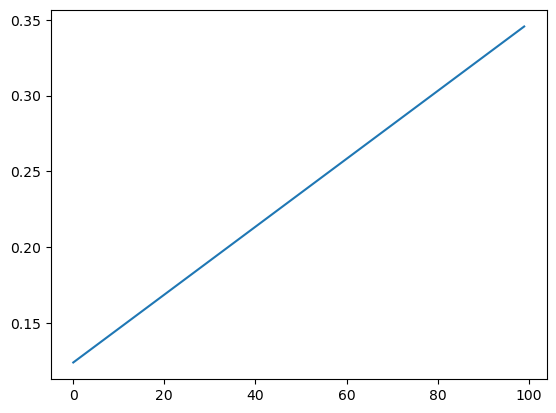

In [56]:
plt.figure()
plt.plot(res['average'][0])
plt.show()

In [54]:
def partial_dependence(model, X, feature_indices, grid_points=100, device='cpu'):
    """
    Compute partial dependence of one or more features.

    Parameters:
    - model: a trained model (PyTorch)
    - X: input data (torch.Tensor)
    - feature_indices: indices of the features for which partial dependence should be computed
    - grid_points: number of points for which to calculate partial dependence
    - device: computation device ('cpu' or 'cuda')
    
    Returns:
    - feature_values: list of arrays of feature values for each feature
    - pdp_values: array of corresponding partial dependence values
    """
    model.eval()
    model = model.to(device)
    X = X.to(device)
    
    # Ensure feature_indices is a list
    if isinstance(feature_indices, int):
        feature_indices = [feature_indices]
    
    # Create grid for each feature
    feature_values = [np.linspace(X[:, idx].min(), X[:, idx].max(), grid_points) for idx in feature_indices]
    
    # Get all combinations of feature values
    grid_combinations = list(itertools.product(*feature_values))
    
    pdp_values = []
    for grid_point in grid_combinations:
        X_temp = X.clone().detach()
        for idx, feature_idx in enumerate(feature_indices):
            X_temp[:, feature_idx] = grid_point[idx]
        pdp_values.append(model(X_temp).mean().item())
    
    return feature_values, pdp_values

In [55]:
model = torch.nn.Linear(2, 1)
# Create some synthetic data
X = torch.randn(10000, 2)
model.weight

Parameter containing:
tensor([[ 0.4512, -0.2146]], requires_grad=True)

In [58]:

# Compute partial dependence for feature 0
_, pd_0 = partial_dependence(model, X, [0])
pd_0.mean()

AttributeError: 'list' object has no attribute 'mean'

In [49]:
# Compute partial dependence for feature 0
pd_1 = partial_dependence(model, X, [1], verbose=False)
pd_1.mean()

tensor(-0.6400, grad_fn=<MeanBackward0>)

Parameter containing:
tensor([[0.0453, 0.4189]], requires_grad=True)

In [37]:
pd_0

tensor([0.5070, 0.4280, 0.4450, 0.4893, 0.4574, 0.4786, 0.4179, 0.4507, 0.4379,
        0.4681, 0.5090, 0.3792, 0.4157, 0.4339, 0.4619, 0.4395, 0.4010, 0.5666,
        0.4816, 0.4357, 0.4834, 0.4356, 0.3879, 0.4539, 0.4373, 0.5520, 0.5041,
        0.4849, 0.4383, 0.5110, 0.4773, 0.4750, 0.4909, 0.3928, 0.4581, 0.4560,
        0.4709, 0.4248, 0.4211, 0.4841, 0.4135, 0.4466, 0.4656, 0.4989, 0.4835,
        0.4389, 0.4328, 0.4284, 0.4366, 0.4480, 0.4410, 0.4145, 0.4737, 0.4928,
        0.4247, 0.4880, 0.4453, 0.4843, 0.5010, 0.4601, 0.4565, 0.4555, 0.4440,
        0.4561, 0.3425, 0.4378, 0.4579, 0.5260, 0.4488, 0.4587, 0.3995, 0.4562,
        0.4864, 0.4238, 0.3980, 0.4788, 0.4154, 0.3813, 0.4889, 0.4016, 0.4544,
        0.4545, 0.4044, 0.4043, 0.4341, 0.5142, 0.4249, 0.3882, 0.4531, 0.4918,
        0.3841, 0.4437, 0.4037, 0.4172, 0.4308, 0.4429, 0.4173, 0.4707, 0.4739,
        0.5463, 0.4311, 0.4262, 0.4307, 0.5153, 0.4472, 0.4431, 0.4191, 0.4544,
        0.3684, 0.4251, 0.4639, 0.3510, 